# Imports

In [156]:
import pandas as pd, numpy as np, yaml, os, seaborn as sns, hypercluster as hc, matplotlib.pyplot as plt, matplotlib
import sklearn, umap
from wand.image import Image as WImage
from matplotlib.cm import ScalarMappable

sns.set(style = 'white', color_codes=True, font_scale = 1.3)
matplotlib.rcParams.update({'savefig.bbox': 'tight', 'savefig.dpi': '500'})
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

# Read in data and prepare input tables

In [20]:
input_data_prefix = 'sc_data'
gold_standard_file = 'gold_standard.csv'

In [21]:
meta_data = pd.read_csv('seurat_igor_meta.tsv', sep='\t', index_col=-1)
untreated_cells = meta_data[meta_data['orig.ident'].isin(['lepr', 'col23', 'vecad'])].index
labels = meta_data.loc[untreated_cells, ['cluster']]
labels.to_csv(gold_standard_file)

df = pd.read_csv('sc_data_normed_2000mostvar.csv', index_col=0)
df.columns = [i.replace('.', ':') for i in df.columns]
df = df[untreated_cells].transpose()
df.to_csv('%s.csv' % input_data_prefix)

# Edit config

In [55]:
with open('config.yml', 'r') as fh:
    config = yaml.load(fh)

/gpfs/data/ruggleslab/home/lmb529/conda/envs/hc_test/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [61]:
config['input_data_folder'] = os.path.abspath('.')
config['input_data_files'] = [input_data_prefix]
config['gold_standards'] = {input_data_prefix: gold_standard_file}
config['read_csv_kwargs'] = {input_data_prefix:{'index_col': [0]}}
config['evaluations'] = sorted(list(set(hc.constants.need_ground_truth + hc.constants.inherent_metrics)))
config['screeplot_evals'] = sorted(list(set(hc.constants.need_ground_truth + hc.constants.inherent_metrics)))
config['metric_to_choose_best']  = 'adjusted_rand_score'
config['metric_to_compare_labels']  = 'adjusted_rand_score'
config['compare_samples'] = False

nclusters = [i for i in range(3, 40)]
graph_params = {
    'k':[20, 30, 40, 80, 120], 
    'resolution':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6]
}
config['optimization_parameters']['KMeans'] = {'n_clusters':nclusters}
config['optimization_parameters']['NMFCluster'] = {'n_clusters':nclusters}
config['optimization_parameters']['MiniBatchKMeans'] = {'n_clusters':nclusters}
config['optimization_parameters']['LouvainCluster'] = graph_params
config['optimization_parameters']['LeidenCluster'] = graph_params

In [62]:
with open('config.yml', 'w') as fh:
    yaml.dump(config, stream=fh)

# Running snakemake

In [63]:
%%bash
module add slurm
sbatch snakemake_submit.sh

Submitted batch job 6147579


# Visualizing results

In [151]:
new_labels = pd.read_csv('results/%s/clustering/labels.txt' % input_data_prefix, index_col=0)
evals = pd.read_csv('results/%s/clustering/evaluations.txt' % input_data_prefix, index_col=0)

new_labels = new_labels[new_labels.columns[(new_labels==-1).sum()==0]]
best_labels = evals.columns[evals.loc['adjusted_rand_score', :] == evals.loc['adjusted_rand_score', :].max()][0]

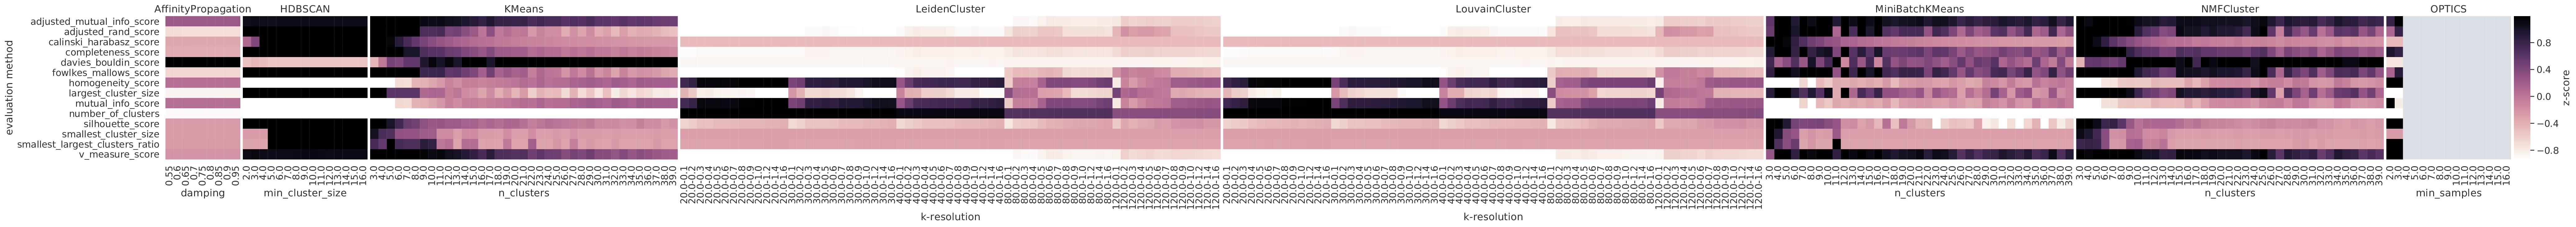

In [76]:
img = WImage(filename='results/sc_data/clustering/evaluations.pdf', resolution=150)
img

In [115]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(df)
embedding = pd.DataFrame(embedding, index=df.index, columns=['UMAP1', 'UMAP2'])
embedding['published_labels'] = labels.reindex(embedding.index)
embedding['best_labels'] = new_labels[best_labels].reindex(embedding.index)

/gpfs/data/ruggleslab/home/lmb529/conda/envs/hc_test/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../conda/envs/hc_test/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/gpfs/data/ruggleslab/home/lmb529/conda/envs/hc_test/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


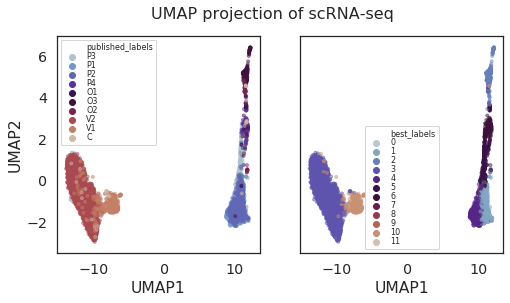

In [117]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 4), sharey=True)

for i, labs in enumerate(['published_labels', 'best_labels']):
    sns.scatterplot(
        'UMAP1','UMAP2', data = embedding, 
        hue=labs, s=10, 
        palette=sns.color_palette('twilight', n_colors=len(embedding[labs].unique())), edgecolor=None, alpha=0.5,
        ax=axs[i], 
    )
    plt.suptitle('UMAP projection of scRNA-seq', fontsize=16, y=0.98)
    axs[i].legend(loc='best', fontsize=8, labelspacing=0, edgecolor=None, facecolor=None)
plt.savefig('figures/umap.best_labels.pdf')

In [119]:
reducer = sklearn.decomposition.PCA(n_components=2)
embedding = reducer.fit_transform(df)
embedding = pd.DataFrame(embedding, index=df.index, columns=['PC1', 'PC2'])
embedding['published_labels'] = labels.reindex(embedding.index)
embedding['best_labels'] = new_labels[best_labels].reindex(embedding.index)

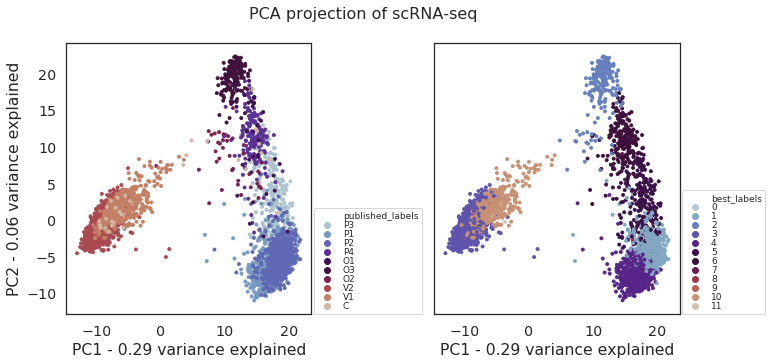

In [130]:
fig, axs = plt.subplots(ncols=2, figsize=(11, 5), sharey=True, gridspec_kw=dict(wspace=0.5))

for i, labs in enumerate(['published_labels', 'best_labels']):
    ax=axs[i]
    sns.scatterplot(
        'PC1','PC2', 
        data = embedding, 
        hue=labs, s=10, 
        palette=sns.color_palette('twilight', n_colors=len(embedding[labs].unique())), 
        ax=ax,
        edgecolor=None
    )
    ax.set_xlabel('PC1 - %.2f variance explained' % reducer.explained_variance_ratio_[0])
    ax.set_ylabel('PC2 - %.2f variance explained' % reducer.explained_variance_ratio_[1])
    
    ax.legend(loc=(1.01, 0), labelspacing=0, fontsize=9)
plt.suptitle('PCA projection of scRNA-seq', fontsize=16)
plt.savefig('figures/pca.best_labels.pdf')

# Investigating parameters in graph based clustering

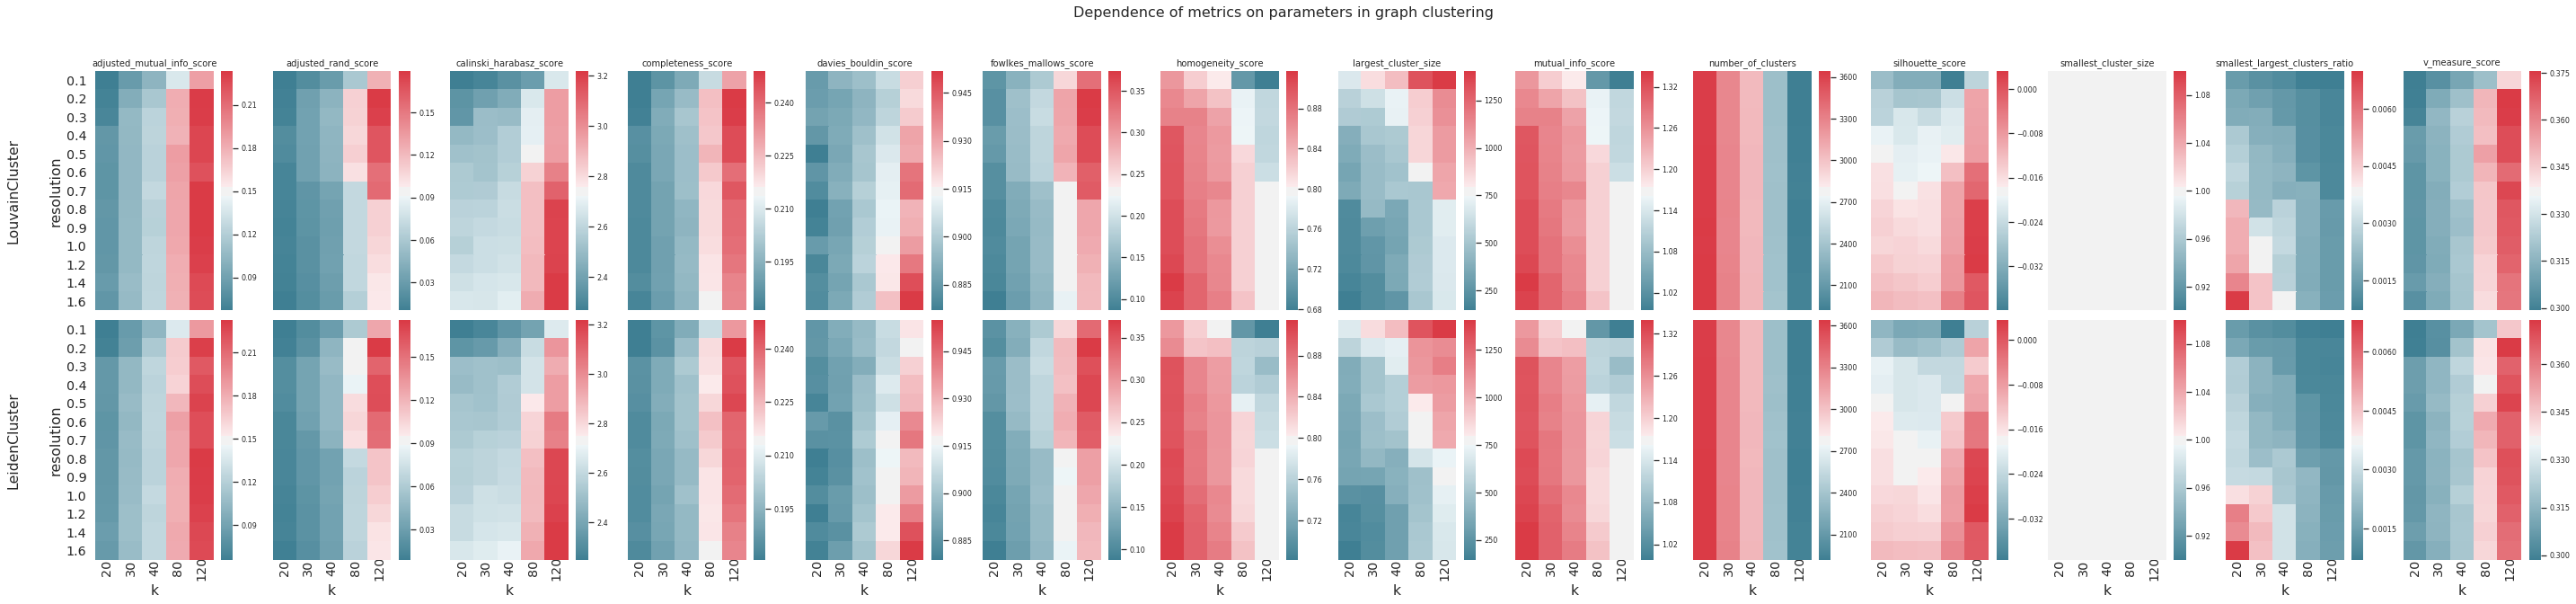

In [144]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
cmap.set_bad('#BDBDBD')
cmap.set_over('#9E031A')
cmap.set_under('#0C4A60')

fig, axs = plt.subplots(
    ncols = len(evals), 
    nrows=2,
    figsize=(3.5*len(evals), 10),
    gridspec_kw=dict(hspace=0.04, wspace=0.2),
    sharey=True, sharex=True
)

for row, method in enumerate(['LouvainCluster', 'LeidenCluster']):
    df = hc.utilities.convert_to_multiind(method, evals).transpose()
    for col, metric in enumerate(df.columns):
        ax = axs[row, col]
        visdf = df[metric].unstack().transpose()
        sns.heatmap(visdf, xticklabels=visdf.columns,yticklabels=visdf.index, cmap=cmap, ax=ax)
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=8)
        if col > 0:
            ax.set_ylabel('')
        if row == 0:
            ax.set_xlabel('')
            ax.set_title(metric, fontsize=10)
        ax.set_yticklabels(visdf.index, rotation=0)
        ax.set_xticklabels([int(i) for i in visdf.columns], rotation=90, va='center')
        
axs[0,0].text(-0.75, 0.5, 'LouvainCluster', rotation=90, va='center', transform=axs[0,0].transAxes)
axs[1,0].text(-0.75, 0.5, 'LeidenCluster', rotation=90, va='center', transform=axs[1,0].transAxes)

fig.suptitle('Dependence of metrics on parameters in graph clustering', y=0.98,  fontsize=16)
plt.savefig('figures/heatmaps.graphs-clusterers.metrics.pdf')

In [186]:
data = pd.read_csv('sc_data.csv', index_col=0)

In [196]:
# method = 'LeidenCluster'
method = 'LouvainCluster'
metric = 'adjusted_rand_score'
labels_temp = hc.utilities.convert_to_multiind(method, new_labels).transpose()
eval_temp = hc.utilities.convert_to_multiind(method, evals).transpose()

/gpfs/data/ruggleslab/home/lmb529/conda/envs/hc_test/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../conda/envs/hc_test/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))


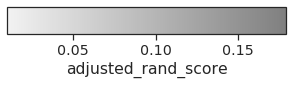

In [197]:
eval_data = eval_temp[metric]

embedding = umap.UMAP(n_components=2).fit_transform(data)
embedding = pd.DataFrame(embedding, index=data.index, columns=['UMAP1', 'UMAP2'])

params = labels_temp.index
ks = sorted(list(set(params.get_level_values(0))))
ress = sorted(list(set(params.get_level_values(1))))

sm = ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=eval_data.min(), vmax=eval_data.max()), 
    cmap=sns.light_palette('gray', as_cmap=True), 
)
facecolors = sm.to_rgba(eval_data)
fig, ax = plt.subplots(figsize=(5, 0.5))
plt.colorbar(mappable=sm, label=metric, cax=ax, orientation='horizontal')
plt.savefig('figures/colorbar.%s-%s.pdf' % (method, metric))

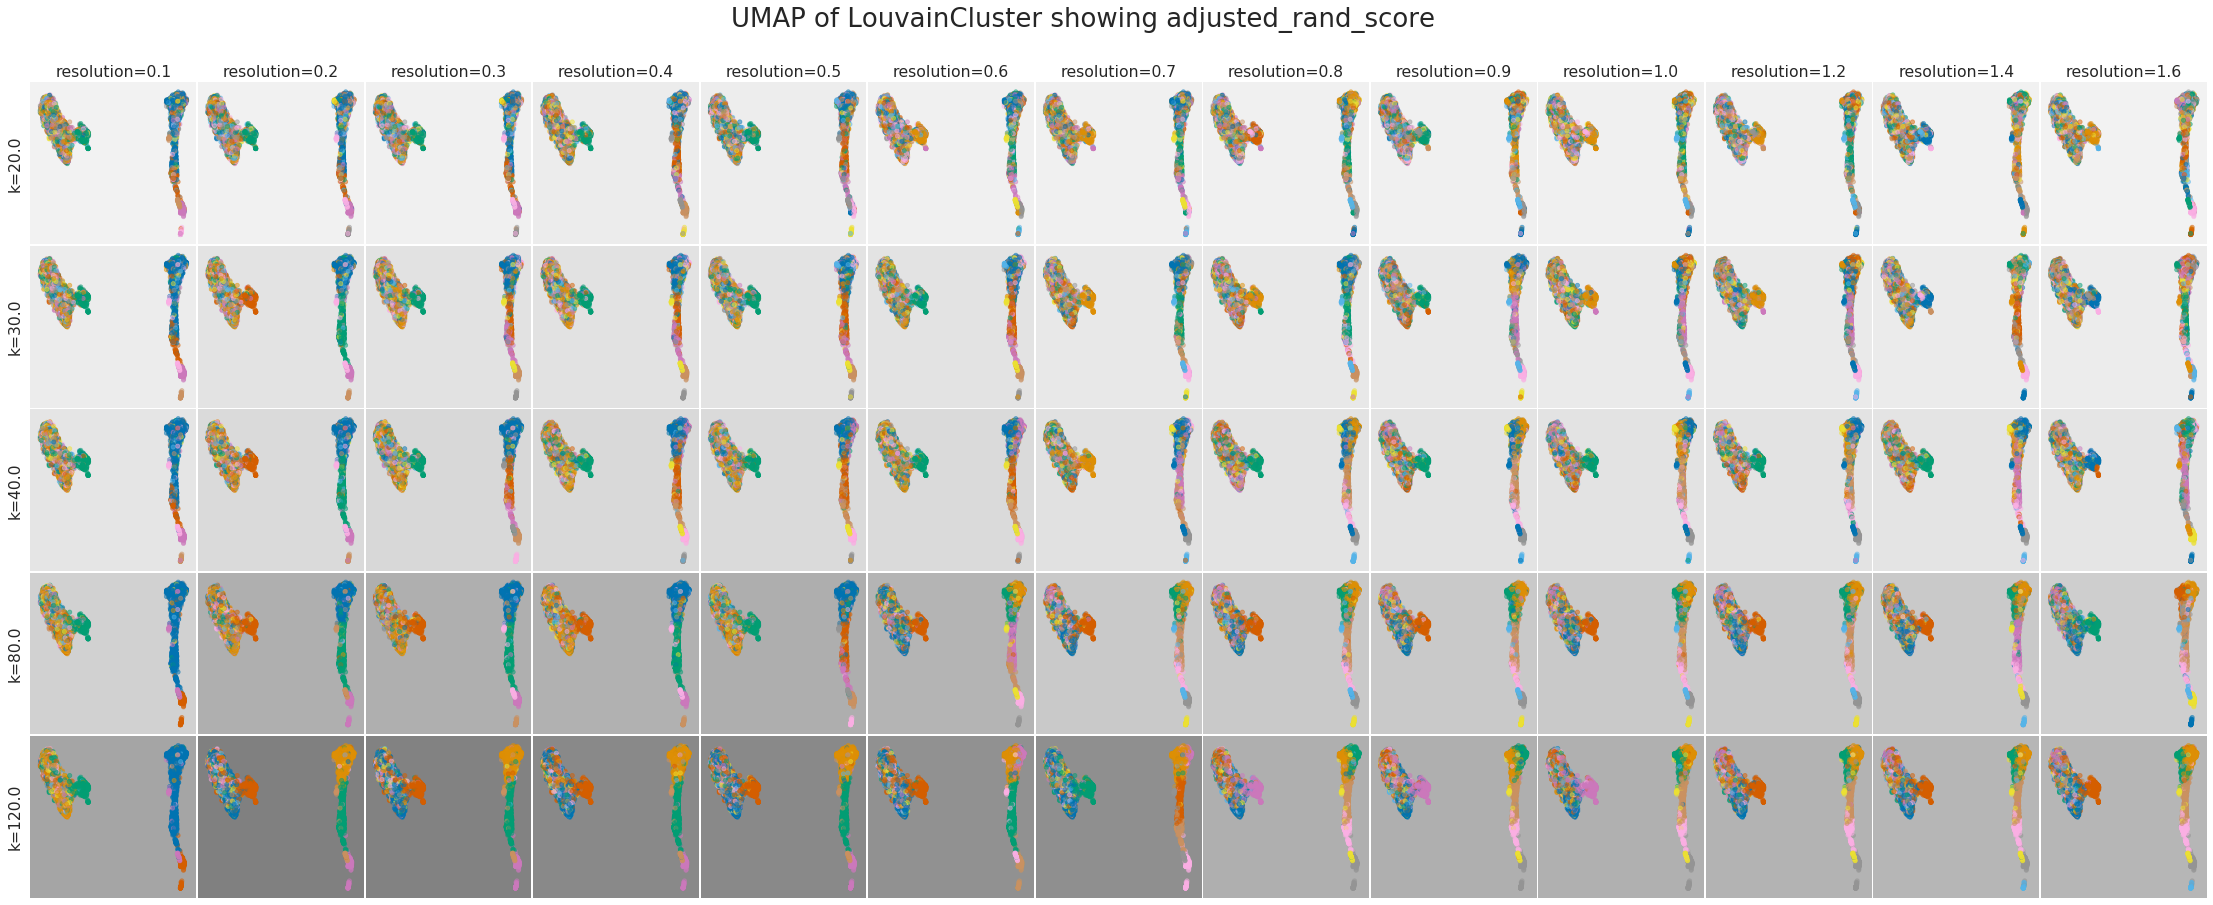

In [198]:
fig, axs = plt.subplots(
    figsize=(3*len(ress), 3*len(ks)),
    nrows=len(ks),
    ncols=len(ress),
    sharex=True,
    sharey=True,
    gridspec_kw=dict(
        hspace=0.01, wspace=0.01,
    )
)

for row, k in enumerate(ks):
    for col, resolution in enumerate(ress):
        facecolor = matplotlib.colors.to_hex(facecolors[eval_data.index.get_loc((k, resolution))])
        ax = axs[row, col]
        temp = labels_temp.loc[[(k, resolution)]].transpose()
        temp.columns = ['%s;%s-%s;%s-%s' % (method,'resolution', resolution, 'k', k)]

        temp = pd.concat([temp, embedding], axis=1)
        
        sns.scatterplot(
            x='UMAP1',
            y='UMAP2',
            hue=temp.columns[0],
            palette=sns.color_palette('colorblind', n_colors=len(temp[temp.columns[0]].unique())),
            data=temp,
            ax=ax,
            size=25,
            legend=False,
            alpha=0.5,
            edgecolor=None
        )
        if col == 0:
            axs[row, 0].text(-0.05, 0.5, '%s=%s' % ('k', k), va='center', ha='right',rotation=90, transform=ax.transAxes)
        
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
            
        for spine in ax.spines.values():
            spine.set_visible(False)
            
        ax.patch.set_facecolor(facecolor)

        if row == 0:
            ax.set_title('%s=%s' % ('resolution', resolution))
fig.suptitle('UMAP of %s showing %s' % (method, metric), fontsize=26, y=0.95)
plt.savefig('figures/grid.scatter.%s-%s-umaps.pdf' %(method, metric), dpi=100)

# NMF seems to do well, checking that out too

In [200]:
method = 'NMFCluster'
metric = 'adjusted_rand_score'

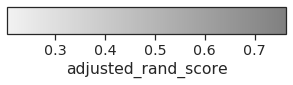

In [205]:
eval_data = hc.utilities.convert_to_multiind(method, evals).transpose()[metric]

pca_model = sklearn.decomposition.PCA(n_components=2)
embedding = pca_model.fit_transform(data)
embedding = pd.DataFrame(embedding, index=data.index, columns=['PCA1', 'PCA2'])

sm = ScalarMappable(
    norm=matplotlib.colors.Normalize(vmin=eval_data.min(), vmax=eval_data.max()), 
    cmap=sns.light_palette('gray', as_cmap=True), 
)

facecolors = sm.to_rgba(eval_data)
fig, ax = plt.subplots(figsize=(5, 0.5))
plt.colorbar(mappable=sm, label=metric, cax=ax, orientation='horizontal')
plt.savefig('figures/colorbar.%s-%s.pdf' % (method, metric))

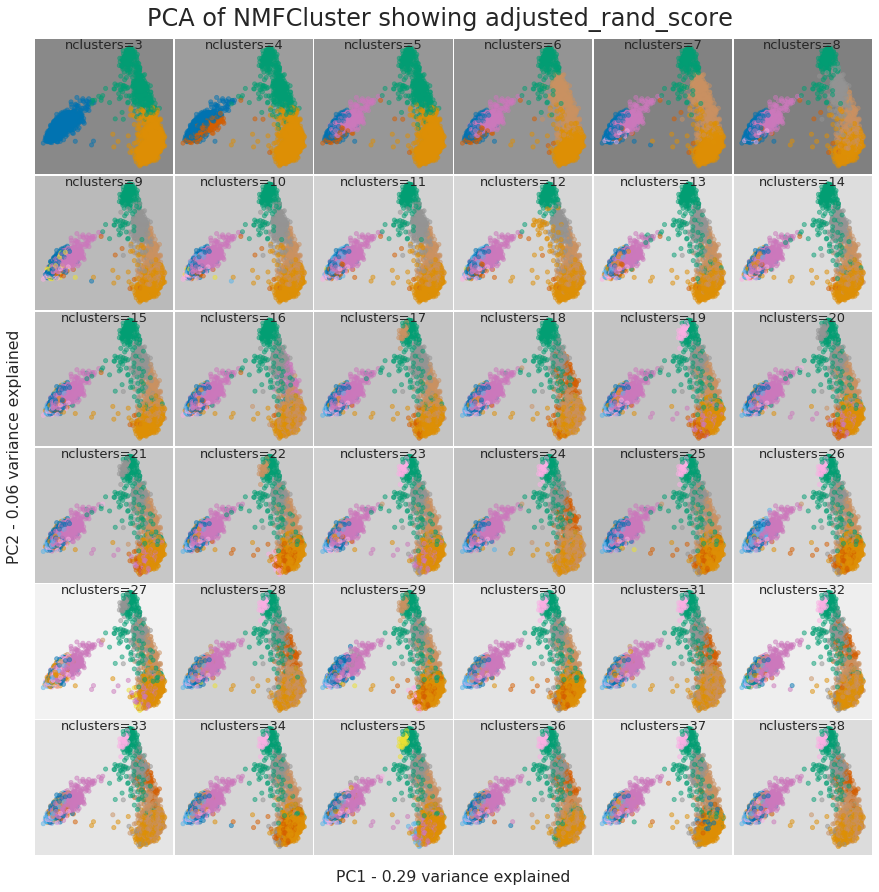

In [216]:
fig, axs = plt.subplots(
    figsize=(2.5*6, 2.5*6),
    nrows=6,
    ncols=6,
    sharex=True,
    sharey=True,
    gridspec_kw=dict(
        hspace=0.01, wspace=0.01,
    )
)
axs = [ax for lis in axs for ax in lis]

for i, n_clusters in enumerate(range(3, 39)):

    facecolor = matplotlib.colors.to_hex(facecolors[i])
    ax = axs[i]
    temp = hc.utilities.convert_to_multiind(method, new_labels)[[n_clusters]].astype(float)
    temp = pd.concat([temp, embedding], axis=1)

    sns.scatterplot(
        x='PCA1',
        y='PCA2',
        hue=temp.columns[0],
        palette=sns.color_palette('colorblind', n_colors=len(temp[temp.columns[0]].unique())),
        data=temp,
        ax=ax,
        size=28.5,
        legend=False,
        alpha=0.5,
        edgecolor=None
    )

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.patch.set_facecolor(facecolor)

    ax.set_title('%s=%s' % ('nclusters', n_clusters), va='top', fontsize=13, pad=0.1)
    
axs[32].text(1, -0.2, 'PC1 - %.2f variance explained' %(pca_model.explained_variance_ratio_[0]), ha='center', transform=axs[32].transAxes)
axs[12].text(-0.2, 0, 'PC2 - %.2f variance explained' %(pca_model.explained_variance_ratio_[1]), va='center', rotation=90, transform=axs[12].transAxes)
fig.suptitle('PCA of %s showing %s' % (method, metric), fontsize=24, y=0.91)
plt.savefig('figures/grid.scatter.%s-%s-pca.pdf' %(method, metric), dpi=100)